In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter, OrderedDict
from itertools import combinations
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import csv
import numpy as np
import os
import subprocess 
import re
import seaborn as sns
import networkx as nx
import errno

%matplotlib inline

In [2]:
datadir='/nasdata/Vincent/Distance/'
mibigFolder='/nasdata/DBs/MIBiG_1.4_august2018/'
antismashFolder='/nasdata/DBs/antismashDB_august2018/'

LIBS = { 
         'ARAZ' : ['AD','KS','END','AHBA','CAP'],
         'OR13' : ['AD','KS','END'],
         'AZ52' : ['AD','KS','AHBA'],
         'HI03' : ['AD']
       }

### Extract protein sequence from networks 

In [3]:
## -prepare fasta files from graphml files
## -for later reference, add numbers to networks in graphml files
## -count number of nodes per network

lenNetworksDict={} # keys is network name, value is how many nodes it contains
nbNetworksPerSoil={}

for filename in os.listdir(datadir+'inputGraphmls/'): 
    if filename.endswith(".graphml"):
        networkFileIn = datadir+'inputGraphmls/'+filename
        networkFileOut = networkFileIn.replace('inputGraphmls/', 'numberedGraphmls/').replace('_COMPRESSED','_NUMBERED')     
        soilName = filename.split('_COMPRESSED')[0].split('NETWORKS#')[1]
        fastaFolderName = datadir+'fastaFolder/'+soilName+'/'
        if not os.path.exists(os.path.dirname(fastaFolderName)):
            try:
                os.makedirs(os.path.dirname(fastaFolderName))
            except OSError as exc: 
                if exc.errno != errno.EEXIST:
                    raise

        soilGraph = nx.read_graphml(networkFileIn)
        soilGraph = soilGraph.to_undirected()

        print soilName
        print str(nx.number_of_nodes(soilGraph))+" nodes"
        print str(nx.number_connected_components(soilGraph))+" networks"

        nx.set_node_attributes(soilGraph, 'subgraphTagNumber','0')
        dict_subgraphTagNumber={}
        netNumber=0
        for subgraph in nx.connected_component_subgraphs(soilGraph, copy=False):
            if 2<subgraph.number_of_nodes()<30:
                netNumber+=1
                netName=soilName[:4]+'-'+str(netNumber)                        
                subgraphFasta= fastaFolderName+netName+'_domains.faa'
                with open(subgraphFasta,'wb') as outfile:
                    tagNumber=0
                    for n in subgraph.nodes(): 
                        try:
                            if soilGraph.node[n]['domain'][-2:] == 'AD' or soilGraph.node[n]['domain'][-2:] =='KS':
                                tagNumber+=1
                                frames=['a','b','c']
                                for idx,f in enumerate(frames):
                                    tagName='>'+netName+'_#'+soilGraph.node[n]['domain'][-2:]+str(tagNumber)+f
                                    coding_dna=soilGraph.node[n]['seq']
                                    coding_dna=coding_dna[idx:]
                                    coding_dna=Seq(coding_dna, generic_dna)
                                    proteinSeq=coding_dna.translate(to_stop=True)
                                    if len(proteinSeq) > 60:
                                        spamwriter = csv.writer(outfile,delimiter=',')
                                        spamwriter.writerow([tagName])
                                        spamwriter.writerow([proteinSeq])

                                #update graphml file with domain names and numbers
                                dict_subgraphTagNumber[n]=tagName[:-1]
                        except:
                            pass
                    lenNetworksDict[netName]=tagNumber
    
        nx.set_node_attributes(soilGraph, name='subgraphTagNumber',values=dict_subgraphTagNumber)
        nx.write_graphml(soilGraph, networkFileOut)

        #concatenate all fasta files into .fna
        os.chdir(fastaFolderName)
        subprocess.call("cat *.faa > "+soilName[:4]+".fnaa", shell=True)

        nbNetworksPerSoil[soilName[:4]]=netNumber
        print str(netNumber)+" fasta files of networks with >=3 domains"
        print ''


ARAZ_AD#ARAZ_AHBA#ARAZ_CAP#ARAZ_END#ARAZ_KS_1e-06
10341 nodes
3414 networks


/ru-auth/local/home/vlibis/anaconda2/lib/python2.7/site-packages/Bio/Seq.py:2576: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


1233 fasta files of networks with >=3 domains

OR13_AD#OR13_END#OR13_KS_1e-06
8794 nodes
3093 networks
1057 fasta files of networks with >=3 domains

HI03_AD_1e-06
4209 nodes
994 networks
343 fasta files of networks with >=3 domains

AZ52_AD#AZ52_AHBA#AZ52_KS_1e-06
10042 nodes
2747 networks
929 fasta files of networks with >=3 domains



### Extract protein sequence from reference BGCs 

In [293]:
def extractProteins(genbankFile):
    with open(genbankFile, "rU") as input_handle:
        with open(genbankFile.replace('.gbk','.faa') , "w") as output_handle:
            CDScounter=0
            sequences = SeqIO.parse(input_handle, "genbank") 
            for record in sequences:
                record.id=record.description.split(' ')[0]+"_"+record.id
                record.description=record.id
                for seq_feature in record.features :
                    if seq_feature.type=="CDS" :
                        if len(seq_feature.qualifiers['translation'][0])>180:
                            CDScounter+=1
                            output_handle.write(">%s_%s\n%s\n" % (
                                   record.id,
                                   str(CDScounter),
                                   seq_feature.qualifiers['translation'][0]))
                            
if not os.path.exists(mibigFolder+'MIBiG.fnaa'):               
    for filename in os.listdir(mibigFolder):
        if filename.endswith(".gbk"):
            if not os.path.exists(mibigFolder+filename.replace('.gbk','.faa')):
                extractProteins(mibigFolder+filename)
    
    os.chdir(mibigFolder)
    subprocess.call("cat *.faa > MIBiG.fnaa", shell=True)
    
if not os.path.exists(antismashFolder+'antismashDB.fnaa'):
    for filename in os.listdir(antismashFolder): 
        if filename.endswith(".gbk"):
            if not os.path.exists(antismashFolder+filename.replace('.gbk','.faa')):
                extractProteins(antismashFolder+filename)
    
    os.chdir(antismashFolder)
    subprocess.call("find . -name \*.faa -exec cat {} \; > antismashDB.fnaa", shell=True) #concatenates lots of files
    #merge MIBIG and antismashDB as "knowns"
    subprocess.call("cat antismashDB.fnaa "+mibigFolder+"MIBiG.fnaa > knowns.fnaa", shell=True)
    
                

## BlastP all translated amplicons

In [4]:
# create blastp databases and blast soils against each others and reference BGC databases
def checkBlast(datadir,RESULT_FILE,QUERY_FILE,DB_INFILE,DB_OUTFILE):
    if not os.path.exists(DB_OUTFILE+'.pin'):
        subprocess.call(["makeblastdb -in "+DB_INFILE+" -dbtype prot -out "+DB_OUTFILE], shell= True)    
    if os.path.exists(datadir+'blastWorks/'+RESULT_FILE):
        print "already blasted "+RESULT_FILE[:-4]
    else:
        print '-Blasting '+RESULT_FILE[:-4]+'...'
        subprocess.call(["blastp -query "+QUERY_FILE+" -db "+DB_OUTFILE+" -outfmt '10 qseqid sseqid evalue bitscore length pident sstart send' -out blastWorks/"+RESULT_FILE+" -max_target_seqs 2000000 -evalue 1e-20 -qcov_hsp_perc 80 -num_threads 56"], shell=True)

os.chdir(datadir)
for soil1 in LIBS.keys():
    ### 1) blast soil against other soils
    for soil2 in LIBS.keys():
        DB=min(soil1,soil2) #min or max to always keep the same order in the soil names
        query=max(soil1,soil2)
        if soil1 != soil2:
            RESULT_FILE='-VS-'.join([DB,query])+'.csv' 
        else: 
            continue
    
        for filename in os.listdir(datadir+'fastaFolder/'): 
            if filename.startswith(query):
                QUERY_FILE=datadir+'fastaFolder/'+filename+'/'+query+'.fnaa' 
            if filename.startswith(DB):
                DB_INFILE=datadir+'fastaFolder/'+filename+'/'+DB+'.fnaa'
        DB_OUTFILE= datadir+'blastWorks/blastDBs/'+DB 
        #blastp:
        checkBlast(datadir,RESULT_FILE,QUERY_FILE,DB_INFILE,DB_OUTFILE)
    
    ### 2) blast soil against reference BGC databases
    for filename in os.listdir(datadir+'fastaFolder/'): 
        if filename.startswith(soil1):
            QUERY_FILE=datadir+'fastaFolder/'+filename+'/'+soil1+'.fnaa' 
    #blast soil against antismashDB
    DB_OUTFILE=datadir+'blastWorks/blastDBs/antismashDB'
    DB_INFILE=antismashFolder+'knowns.fnaa'
    RESULT_FILE=soil1+'-VS-antismashDB'+'.csv'
    checkBlast(datadir,RESULT_FILE,QUERY_FILE,DB_INFILE,DB_OUTFILE)
    
    #blast soil against MIBiG    
    DB_OUTFILE=datadir+'blastWorks/blastDBs/MIBiG_DB'
    DB_INFILE=mibigFolder+'MIBiG.fnaa'
    RESULT_FILE=soil1+'-VS-MIBiGDB'+'.csv'
    checkBlast(datadir,RESULT_FILE,QUERY_FILE,DB_INFILE,DB_OUTFILE)

print ''
print 'done'

-Blasting ARAZ-VS-OR13...
-Blasting ARAZ-VS-AZ52...
-Blasting ARAZ-VS-HI03...
already blasted ARAZ-VS-antismashDB
already blasted ARAZ-VS-MIBiGDB
already blasted ARAZ-VS-OR13
-Blasting AZ52-VS-OR13...
-Blasting HI03-VS-OR13...
-Blasting OR13-VS-antismashDB...
-Blasting OR13-VS-MIBiGDB...
already blasted ARAZ-VS-AZ52
already blasted AZ52-VS-OR13
-Blasting AZ52-VS-HI03...
-Blasting AZ52-VS-antismashDB...
-Blasting AZ52-VS-MIBiGDB...
already blasted ARAZ-VS-HI03
already blasted HI03-VS-OR13
already blasted AZ52-VS-HI03
-Blasting HI03-VS-antismashDB...
-Blasting HI03-VS-MIBiGDB...

done


### Calculate distance 

In [ ]:
#parse each blast output file 
#create a dataframe (and .csv) containing the scores of each pair
#concatenate dataframes of all the soils

closest_MIBIG_dict={}
closest_antismashDB_dict={}

for blastFile in sorted(os.listdir(datadir+'blastWorks/')):
    
    DB=False  
    if blastFile.endswith(".csv"): 
        if blastFile.endswith("DB.csv"):    
            DB=True  #MIBiG and antismash comparison flag
        blastFile=datadir+'blastWorks/'+blastFile

        blast = pd.read_csv(blastFile,index_col=None,header=None)
        
        blast.columns = ['qseqid', 'sseqid', 'evalue', 'bitscore', 'length', 'pident', 'sstart', 'send']
        blast.sort_values(by='bitscore',ascending=False, inplace=True)  #sort by best Bitscore
        blast.reset_index(drop=True, inplace=True)   
        print str(blastFile.split('/')[-1])+': '+str(len(blast))+" blast hits"

        comparedDomainsDict={}   #key= pair of BGCs, values= list of domains already compared for these BGCs
        ID_Dict={}    #key= pair of BGCs, values= list of bitscores 

        for index, row in blast.iterrows():
            BGC1=row.qseqid.split('_#')[0]
            BGC2=row.sseqid.split('_#')[0]                  
            if BGC1 != '_'.join(BGC2.split('_')[:-1]): #check that the BGC is not being compared to itself
                domain1=row.qseqid[:-1]
                if DB:
                    BGC2='_'.join(BGC2.split('_')[:-1])
                    pair='-VS-'.join([BGC1,BGC2]) #database entry is always last in the pair
                    domain2=row.sstart*int(row.sseqid.split('_')[-1]) #when comparing to database sequences, add the start position as the domain identifier               
                else:    
                    pair='-VS-'.join(sorted([BGC1,BGC2]))
                    domain2=row.sseqid[:-1]       
                
                ## Here we will check if one of the domains has already been used in a previous comparison of the two BGCs
                ## if yes, we do not want to consider this comparison anymore
                ## if not, we can append the score of the comparison in bitscoresDict, and mark these domains as used in comparedDomainsDict
                
                if pair not in comparedDomainsDict: #First time the two BGCs are compared: just add the score
                    comparedDomainsDict[pair]=[domain1,domain2]
                    ID_Dict[pair]=[row.pident]
                         
                else:  ## the BGCs have already been compared at least once:
                    if domain1 not in comparedDomainsDict[pair]:
                        proximityFlag=False
                        if DB:   
                            for position in comparedDomainsDict[pair]:
                                if isinstance(position, (int)): # check if a position (integer) or a tag name
                                    if position-30 < domain2 < position+30:
                                        proximityFlag=True  #flag if the position is within 30AA of a previous one
                                       
                        if domain2 not in comparedDomainsDict[pair] and proximityFlag==False:
                            comparedDomainsDict[pair].append(domain1)
                            comparedDomainsDict[pair].append(domain2)
                            ID_Dict[pair].append(row.pident)
                                
        ### This part populates a dataframe with everything necessary to decide how closely the BGCs are related
        distanceDF=pd.DataFrame(index=ID_Dict.keys() ,columns=['node1','node2','IDs','avgID','nbHits','nbDomains','halfDomainID','maxID'])
        
        def node1(row):  
            return row.name.split('-VS-')[0]
        distanceDF.node1=distanceDF.apply(node1,axis=1)

        def node2(row):
            return row.name.split('-VS-')[1]
        distanceDF.node2=distanceDF.apply(node2,axis=1)
        
        def IDs(row):
            return ID_Dict[row.name]
        distanceDF.IDs=distanceDF.apply(IDs,axis=1)  
        
        def nbHits(row):
            return len(ID_Dict[row.name])
        distanceDF.nbHits=distanceDF.apply(nbHits,axis=1) 
        
        def avgID(row):
            return (sum(ID_Dict[row.name])/len(ID_Dict[row.name])) 
        distanceDF.avgID=distanceDF.apply(avgID,axis=1)  
        
        def nbHits(row):
            return len(ID_Dict[row.name])
        distanceDF.nbHits=distanceDF.apply(nbHits,axis=1)

        def nbDomains(row):
            try:
                return [lenNetworksDict[row.node1.split('_')[0]],lenNetworksDict[row.node2.split('_')[0]]]
            except:
                return [lenNetworksDict[row.node1]]
        distanceDF.nbDomains=distanceDF.apply(nbDomains,axis=1) 

        def halfDomainID(row):
            halfNbDomains=math.ceil(min(row.nbDomains)/2.0)
            if row.nbHits >= 2 and row.nbHits >= halfNbDomains:
                bestHalf=sorted(row.IDs)[-int(halfNbDomains):]
                return min(bestHalf)
            else:
                return None
        distanceDF.halfDomainID=distanceDF.apply(halfDomainID,axis=1) 

        def maxID(row):
            return max(row.IDs)
        distanceDF.maxID=distanceDF.apply(maxID,axis=1) 

        distanceDFcsv=datadir+'distanceCSVfiles/distance_3may_all_VS_all_VS_DBs.csv' 
        if os.path.exists(distanceDFcsv): 
            distanceDFfull=pd.read_csv(distanceDFcsv, index_col=0) 
            distanceDFfull=distanceDFfull.append(distanceDF)
            distanceDFfull=distanceDFfull[~distanceDFfull.index.duplicated(keep='first')]
            distanceDFfull.to_csv(distanceDFcsv) 
        else:
            distanceDF.to_csv(distanceDFcsv)
            
        ### plot histogram of network %ID vs knowns (top hit vs MIBIG) and known unknowns (top hit vs AntismashDB)
        if DB:
            linkedDF=distanceDF.loc[distanceDF.halfDomainID>75]
            linkedDF=linkedDF.sort_values(by="halfDomainID", ascending=False)
            linkedDF = linkedDF.drop_duplicates(subset=['node1'])
            soil=blastFile.split('/')[-1][:4]
            if blastFile.endswith("antismashDB.csv"):
                closest_antismashDB_dict[soil]=linkedDF["halfDomainID"].tolist()
                for i in range(nbNetworksPerSoil[soil]-len(linkedDF)):
                    closest_antismashDB_dict[soil].append(74)  ## Histogram visualization: if no hits >65%ID networks gets a score of 64%
                
            if blastFile.endswith("MIBiGDB.csv"):
                closest_MIBIG_dict[soil]=linkedDF["halfDomainID"].tolist()
                for i in range(nbNetworksPerSoil[soil]-len(linkedDF)):
                    closest_MIBIG_dict[soil].append(74)
                
print ''
print 'done'

ARAZ-VS-AZ52.csv: 305638 blast hits
ARAZ-VS-HI03.csv: 222371 blast hits
ARAZ-VS-MIBiGDB.csv: 260516 blast hits
ARAZ-VS-OR13.csv: 411331 blast hits
ARAZ-VS-antismashDB.csv: 2381567 blast hits


### Draw similarity bezel

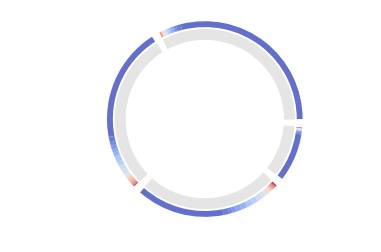

In [12]:
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection

ID_to_knownsDF=pd.DataFrame(columns=closest_antismashDB_dict.keys())
ID_to_knownsDF.ARAZ=pd.Series(closest_antismashDB_dict['ARAZ'])
ID_to_knownsDF.OR13=pd.Series(closest_antismashDB_dict['OR13'])
ID_to_knownsDF.AZ52=pd.Series(closest_antismashDB_dict['AZ52'])
ID_to_knownsDF.HI03=pd.Series(closest_antismashDB_dict['HI03'])
ID_to_knownsDF.to_csv(datadir+'distanceCSVfiles/ID_to_knownsDF_3may.csv')

df = pd.read_csv(datadir+'distanceCSVfiles/ID_to_knownsDF_3may.csv',index_col=0)

bins=[0]
bins.extend(list(np.arange(75, 101, step=1)))
labels = bins[1:]

res = pd.DataFrame(index=labels)
for col in df.columns:
    res[col] = pd.cut(df[col], bins=bins, labels=labels).value_counts()

total_nets = res.sum().sum()
spacer = 5 # deg
deg_df = (res/total_nets)*(360-(spacer*4))

fig, ax = plt.subplots()

patches = []
patches2 = []
colors = []
start= 0
end = -5
for col in deg_df.columns:
    end  = end + 5
    start1=end
    for val in deg_df[col]:
        start = end 
        end = end + val
        patches += [Wedge((0.1, 0.5), 0.2, start, end, width=0.012)]
    patches2 += [Wedge((0.1, 0.5), 0.183, start1, end, width=0.02)]

plt.set_cmap('coolwarm')
colors = range(1,len(bins))
p = PatchCollection(patches, alpha=0.8)
p2 = PatchCollection(patches2, color='#e5e5e5')

p.set_array(np.array(colors))
ax.add_collection(p)
ax.add_collection(p2)
plt.axis('equal')

plt.axis('off')
plt.show()
fig.savefig(datadir+'bezel_3may.pdf', transparent=True)

### Write Chord2 html file

In [ ]:
setThresh=[90]
labels=['ARAZ','OR13','AZ52','HI03']
distanceDFcsv=datadir+'distanceCSVfiles/distance_3may_all_VS_all_VS_DBs.csv'
distanceDFfull=pd.read_csv(distanceDFcsv, index_col=0)

linkedDF=distanceDFfull.loc[distanceDFfull.halfDomainID>setThresh]

linkedDF2=linkedDF.copy()
for index, row in linkedDF2.iterrows():
    if row['node2'].split('_')[-1][:4] not in labels:   ## remove antismash and MIBIG hits
        linkedDF2.drop(index, inplace=True)

G=nx.from_pandas_edgelist(linkedDF2, 'node1', 'node2', edge_attr=['IDs','avgID','nbHits','nbDomains','halfDomainID','maxID'])
G=G.to_undirected()

def origin(node):
    return node.split('_')[-1][:4]

polygonDF=pd.DataFrame(index=labels)
print G.number_of_nodes()
for BGC in G.nodes():
#     print BGC
    
    if origin(BGC) in labels: #ignore antismash hits
        polygon=[origin(BGC)]
        #find which polygon we are dealing with = how many of the labels are there:
        for neighbor in G.neighbors(BGC):
            if origin(neighbor) in labels:
                if origin(neighbor) not in polygon:
                    polygon.append(origin(neighbor))
        #increment polygonDF 
        if len(polygon) > 1:
            polygon.sort()
            polygon='_'.join(polygon)
    
            if polygon not in polygonDF.columns:
                polygonDF[polygon]=0
            polygonDF.loc[origin(BGC),polygon]+=1

## add number of networks that is soil specific
#count total networks in each soil
nbNetDict=dict.fromkeys(labels, 0)
for net in lenNetworksDict.keys():
    for label in labels:
        if net.startswith(label):
            nbNetDict[label]+=1

# totalNets - sharedNets = soilSpecificNets
for label in labels:
    soilSpecific=nbNetDict[label]-sum(polygonDF.loc[label,:])
    polygonDF[label]=0
    polygonDF.loc[label,label]=soilSpecific

cols = polygonDF.columns.tolist()
cols.sort(key=len)
polygonDF = polygonDF [cols]


### Write chord2.js html file
groupLabelDict={}
for idx, val in enumerate(labels):
    groupLabelDict[val]=idx
with open('/nasdata/Vincent/Distance/distanceCSVfiles/chordData90soils_MIBIG_may3.html','w') as outfile:
    
    ## javascript
    outfile.write('<!DOCTYPE html>')
    outfile.write('<meta charset="utf-8">')
    outfile.write('<style>')
    outfile.write('body {')
    outfile.write('font: 10px sans-serif;')
    outfile.write('}')
    outfile.write('</style>')
    outfile.write('<body>')
    outfile.write('<script src="d3.js"></script>')
    outfile.write('<script src="chord2.js"></script>')
    outfile.write('<script>')
    outfile.write('data = {connections: ') 
    outfile.write('[')
    
    
    ## polygons data
    for polygon in polygonDF.columns: 
        if sum(polygonDF[polygon])>1:    
            outfile.write('[')
            for labelIx in polygonDF[polygon].index:           
                if polygonDF.loc[labelIx,polygon]>0:
                    outfile.write('{group: '+str(groupLabelDict[labelIx])+', value: '+str(polygonDF.loc[labelIx,polygon])+'},')
                    print '{group: '+str(groupLabelDict[labelIx])+', value: '+str(polygonDF.loc[labelIx,polygon])+'},'
            outfile.write('],') 
            print ''
    
    ## javascript
    outfile.write('],')
    outfile.write('labels: {0: "AR", 1: "OR", 2: "NM", 3 : "HI"}};')
    outfile.write('data = [data];')
    outfile.write('var width = 1400, height = 1400, padding = .10;')

    outfile.write('chart = d3.chord2()')
    outfile.write('.width(width)')
    outfile.write('.height(height)')
    outfile.write('.padding(padding);')
    outfile.write('d3.select("body")')
    outfile.write('.selectAll("svg")')
    outfile.write('.data(data)')
    outfile.write('.enter()')    
    outfile.write('.append("svg")')    
    outfile.write('.attr("width", width)')
    outfile.write('.attr("height", height)')        
    outfile.write('.call(chart);')
    outfile.write('</script>')
    outfile.close()
